# 결정 트리 (Decision Tree, 의사 결정 트리) 알고리즘

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# matplotlib 한글 폰트 오류 문제 해결 - windows
from matplotlib import font_manager, rc
font_path = "C:\\Windows\\Fonts\\malgun.ttf" # 폰트 파일 위치
font_name = font_manager.FontProperties( fname = font_path ).get_name()
rc( 'font', family = font_name )

# matplotlib 한글 폰트 오류 문제 해결 - mac 
#from matplotlib import rc
#rc( 'font', family = 'AppleGothic' )

# IPython 디스플레이 설정 변경 - 출력할 최대 열의 개수
pd.set_option( 'display.max_columns', 20 ) # 출력할 열의 개수 한도
pd.set_option( 'display.max_colwidth', 20 ) # 출력할 열의 너비
pd.set_option( 'display.unicode.east_asian_width', True ) # 유니코드 사용 너비 조정

import warnings
warnings.filterwarnings('ignore')

## 데이터 준비

In [2]:
red_df = pd.read_csv('data/winequality-red.csv', sep = ';')
white_df = pd.read_csv('data/winequality-white.csv', sep = ';')

red_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
red_df.insert(0, column = 'type', value = 'red')
white_df.insert(0, column = 'type', value = 'white')

In [4]:
wine_df = pd.concat([red_df, white_df])

In [5]:
def integer_encoding(x):
    if x == 'white':
        return 1
    else:
        return 0

In [6]:
wine_df['class'] = wine_df['type'].apply(integer_encoding)

In [7]:
wine_df = wine_df.reset_index()
wine_df.drop('index', axis = 1, inplace = True)

In [8]:
wine_df.to_csv('data/winequality.csv', index = False)

In [9]:
df = wine_df[['type', 'residual sugar', 'pH', 'alcohol', 'class']]
df.rename(columns = {'residual sugar':'sugar'}, inplace = True)
df.head()

,type,sugar,pH,alcohol,class
0,red,1.9,3.51,9.4,0
1,red,2.6,3.20,9.8,0
2,red,2.3,3.26,9.8,0
3,red,1.9,3.16,9.8,0
4,red,1.9,3.51,9.4,0


## 데이터 이해

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   type     6497 non-null   object 
 1   sugar    6497 non-null   float64
 2   pH       6497 non-null   float64
 3   alcohol  6497 non-null   float64
 4   class    6497 non-null   int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 253.9+ KB


In [11]:
df['type'].value_counts()

white    4898
red      1599
Name: type, dtype: int64

In [12]:
df.describe()

,sugar,pH,alcohol,class
count,6497.000000,6497.000000,6497.000000,6497.000000
mean,5.443235,3.218501,10.491801,0.753886
std,4.757804,0.160787,1.192712,0.430779
min,0.600000,2.720000,8.000000,0.000000
25%,1.800000,3.110000,9.500000,1.000000
50%,3.000000,3.210000,10.300000,1.000000
75%,8.100000,3.320000,11.300000,1.000000
max,65.800000,4.010000,14.900000,1.000000


## 결정 트리(Decision Tree)를 통한 모델 생성을 데이터 전처리(data preprocessing)

## 와인 종류 분류 문제(이진 분류)
- 입력 데이터(X) : 당도(sugar), 산도(pH), 알코올 도수(alcohol)
- 정답 데이터(y) : class 1 (양성 클래스) : white 와인, class 0(음성 클래스) : red 와인

In [13]:
# to_numpy() 메서드 : NumPy 배열 생성
data = df[['alcohol', 'sugar', 'pH']].to_numpy() # 입력 데이터(X)
target = df['class'].to_numpy() # 정답 데이터(y)

In [14]:
print(f'data shape : {data.shape}')
print(f'target shape : {target.shape}')

data shape : (6497, 3)
target shape : (6497,)


### 데이터 분리

In [15]:
from sklearn.model_selection import train_test_split
# test_size = 0.2 : 테스트 데이터 세트를 전체 데이터의 20%로 설정
# 별도로 설정하지 않으면 테스트 데이터 세트를 전체 데이터의 25%로 설정
train_input, test_input, train_target, test_target = train_test_split(
    data, target, test_size=0.2, random_state=42)

In [16]:
print(f'train input size : {train_input.shape}\t')
print(f'test input size : {test_input.shape}\t')
print(f'train target size : {train_target.shape}\t')
print(f'test target size : {test_target.shape}\t')

train input size : (5197, 3)	
test input size : (1300, 3)	
train target size : (5197,)	
test target size : (1300,)	


### 특성 표준화

In [17]:
from sklearn.preprocessing import StandardScaler # 특성 표준화 클래스(객체)

In [18]:
ss = StandardScaler() # 특성 표준화 객체(인스턴스, instance) 생성

In [19]:
ss.fit(train_input) # 훈련 데이터 세트를 이용한 특성 표준화 수행(계산 수행)

train_scaled = ss.transform(train_input) # 특성 표준화를 훈련 데이터 세트에 적용
test_scaled = ss.transform(test_input) # 특성 표준화를 테스트 데이터 세트에 적용

In [20]:
print(f'train_scaled : \n{train_scaled[:5,]}\n')
print(f'test_scaled : \n{test_scaled[:5,]}')

train_scaled : 
[[ 0.01376574  0.4646116  -0.16888369]
 [ 1.60871671 -0.70299854  0.26967864]
 [ 1.10504798 -0.70299854  1.20945505]
 [ 1.0211032  -0.89065017  0.958848  ]
 [-0.99357172  2.07007555 -0.67009777]]

test_scaled : 
[[ 1.44082714  1.52797084  0.26967864]
 [-0.48990299 -0.68214836  0.3323304 ]
 [ 1.27293756  0.40206106 -0.23153545]
 [-0.82568214  1.19436794 -0.60744601]
 [-1.32935087  1.75732283 -0.67009777]]


## 결정 트리 (Decision Tree) 알고리즘을 통한 학습(훈련) 및 모델 생성

In [21]:
# 결정 트리(Decision Tree) 알고리즘을 이용한 분류(이진 분류) 문제 해결시 사용하는 클래스(객체)
from sklearn.tree import DecisionTreeClassifier

In [22]:
dt = DecisionTreeClassifier(random_state =42)
dt.fit(train_scaled, train_target)

print(f'훈련 데이터 세트에 대한 score : {dt.score(train_scaled, train_target)}')
print(f'테스트 데이터 세트에 대한 score : {dt.score(test_scaled, test_target)}')

훈련 데이터 세트에 대한 score : 0.996921300750433
테스트 데이터 세트에 대한 score : 0.8592307692307692


- 훈련 데이터 세트에 대한 score는 높고 테스트 데이터 세트에 대한 score는 낮게 나왔는데 차이가 크다.
- 현재 이 모델은 훈련 데이터 세트에 대하여 과대적합(overfitting) 되어 있다고 볼 수 있다.

## 결정 트리 모델 시각화

In [23]:
from sklearn.tree import plot_tree

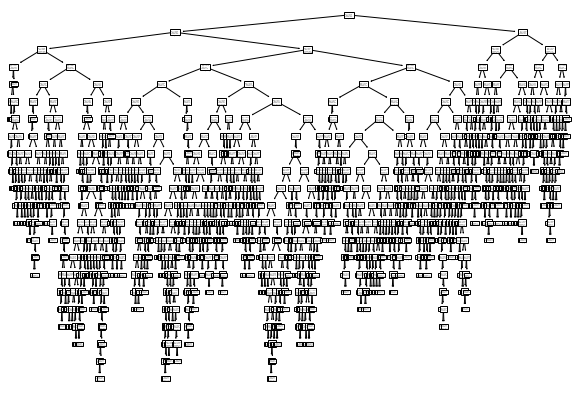

In [24]:
plt.figure(figsize=(10, 7))
plot_tree(dt) #  결정 트리 시각화 함수

plt.show()

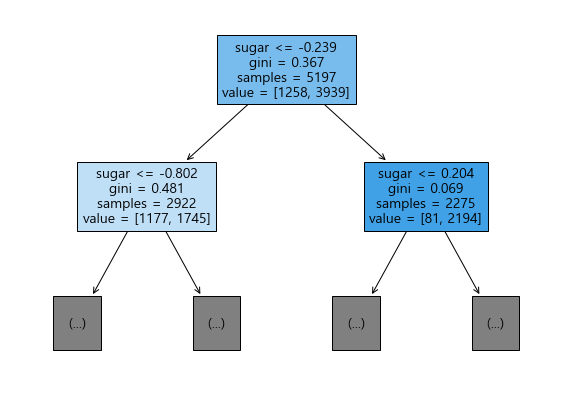

In [25]:
# plot_tree() 함수에서 깊이를 제한해서 출력할 때는 max_depth 매개변수를 1을 주면 루트노드를
# 제외하고 하나의 노드를 더 확장하여 그려준다.
# filled = True : 클래스에 맞게 노드의 색을 칠하고 할 때 사용하는 매개 변수
# feature_names : 특성의 이름을 지정하는 매개 변수
plt.figure(figsize = (10, 7))
plot_tree(dt, max_depth = 1, filled =True,
         feature_names = ['alcohol','sugar','pH'])
plt.show()

## 가지치기를 통한 결정 트리 모델 생성

In [26]:
dt = DecisionTreeClassifier(max_depth = 3, random_state = 42 )
dt.fit(train_scaled, train_target)

print(f'훈련 데이터 세트에 대한 score : {dt.score(train_scaled, train_target)}')
print(f'테스트 데이터 세트에 대한 score : {dt.score(test_scaled, test_target)}')

훈련 데이터 세트에 대한 score : 0.8454877814123533
테스트 데이터 세트에 대한 score : 0.8415384615384616


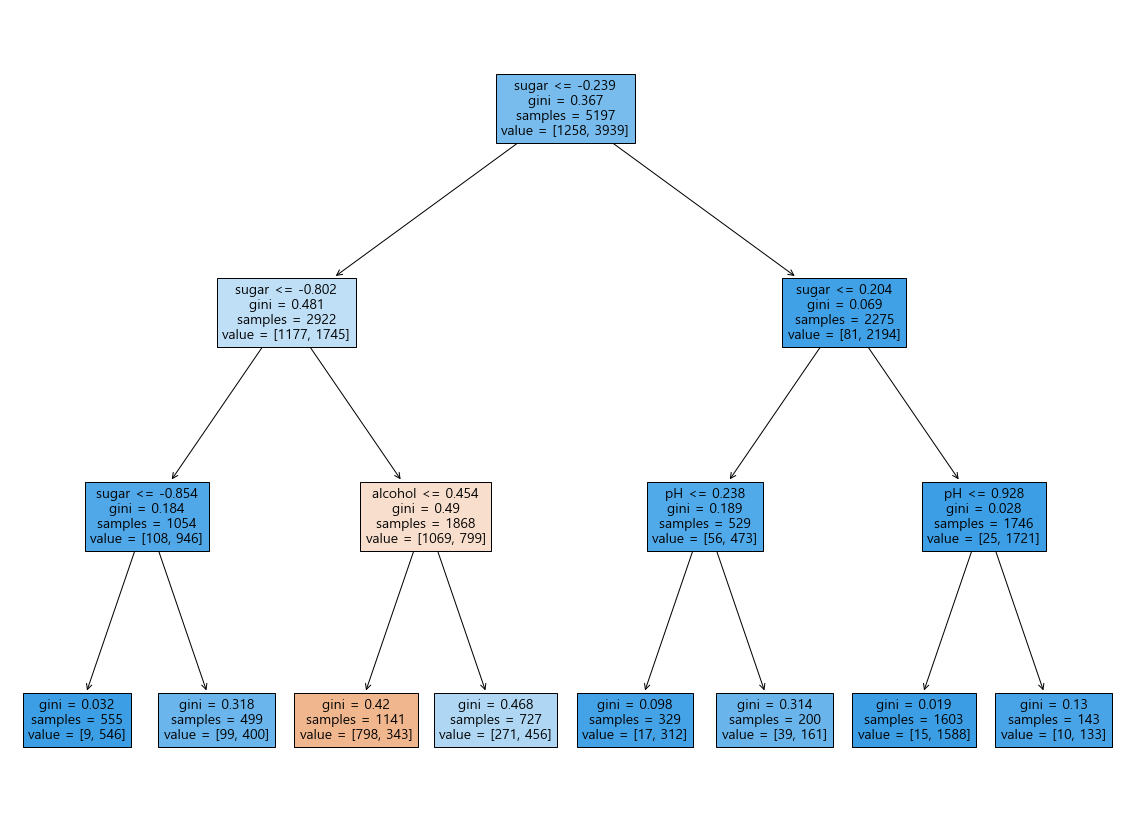

In [27]:
plt.figure(figsize = (20,15))
plot_tree(dt, filled = True,
         feature_names = ['alcohol', 'sugar', 'pH'])
plt.show()

## 특성 표준화를 적용하지 않은 훈련 데이터 세트로 결정 트리 모델 생성
- 특성 표준화를 한 것과 안한 것의 차이가 없다
- 특성 표준화를 해도 되지만 안해도 상관 없다.

In [28]:
dt = DecisionTreeClassifier(max_depth = 3, random_state = 42 )
dt.fit(train_input, train_target)

print(f'훈련 데이터 세트에 대한 score : {dt.score(train_input, train_target)}')
print(f'테스트 데이터 세트에 대한 score : {dt.score(test_input, test_target)}')

훈련 데이터 세트에 대한 score : 0.8454877814123533
테스트 데이터 세트에 대한 score : 0.8415384615384616


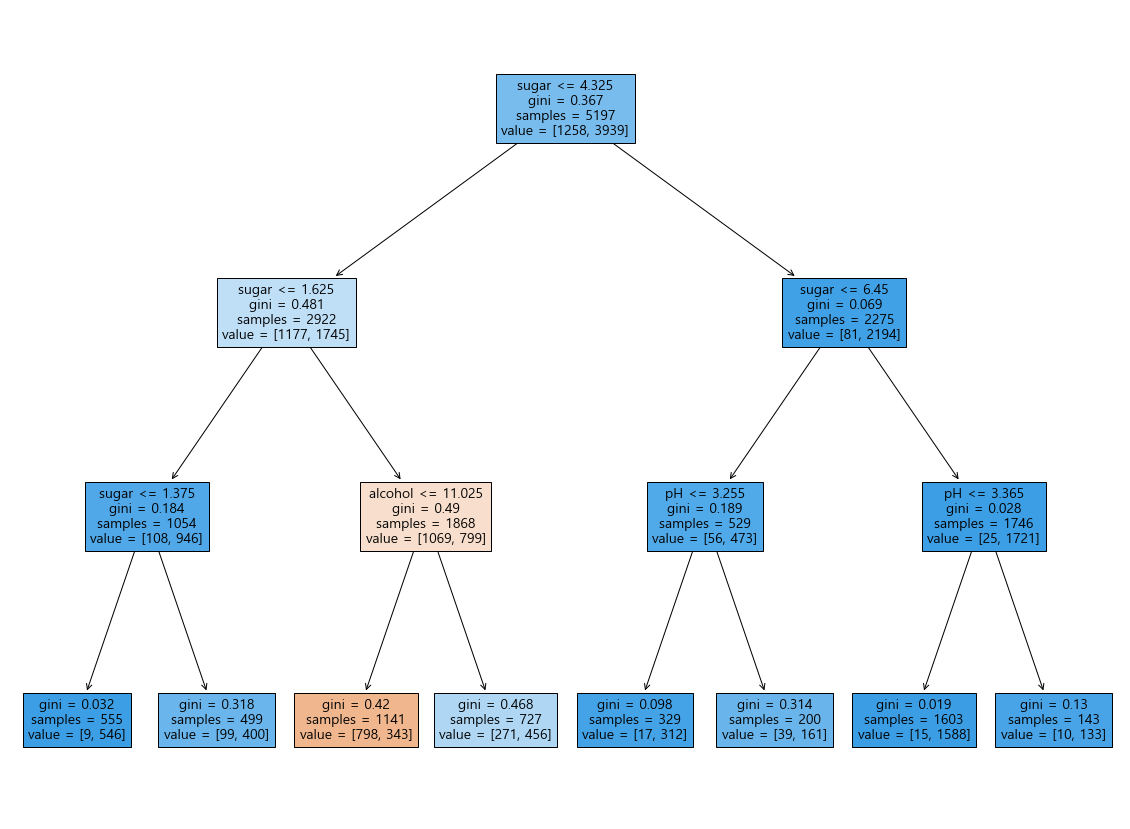

In [29]:
plt.figure(figsize = (20,15))
plot_tree(dt, filled = True,
         feature_names = ['alcohol', 'sugar', 'pH'])
plt.show()

In [30]:
print(f'와인 분류 결정 트리 모델 특성 중요도 : {dt.feature_importances_}')
# 알콜, 당도, 산도 순으로 결과치 출력
# 당도가 특성 중요도가 높다! -> 당도가 중요한 특성이다.

와인 분류 결정 트리 모델 특성 중요도 : [0.12345626 0.86862934 0.0079144 ]


## 교차 검증
### 검증 데이터 세트(  vaildation data set )

In [31]:
print(f'전체 입력 데이터 세트 차원 : {data.shape}')
print(f'전체 정답 데이터 세트 차원 : {target.shape}')

전체 입력 데이터 세트 차원 : (6497, 3)
전체 정답 데이터 세트 차원 : (6497,)


In [32]:
print(f'전체 훈련 데이터 세트 차원(입력 데이터) : {train_input.shape}')
print(f'전체 훈련 데이터 세트 차원(정답 데이터) : {train_target.shape}')

전체 훈련 데이터 세트 차원(입력 데이터) : (5197, 3)
전체 훈련 데이터 세트 차원(정답 데이터) : (5197,)


In [33]:
print(f'전체 테스트 데이터 세트 차원(입력 데이터) : {test_input.shape}')
print(f'전체 테스트 데이터 세트 차원(정답 데이터) : {test_target.shape}')

전체 테스트 데이터 세트 차원(입력 데이터) : (1300, 3)
전체 테스트 데이터 세트 차원(정답 데이터) : (1300,)


## 검증 데이터 세트 생성

In [34]:
sub_input, val_input, sub_target, val_target = train_test_split(
    train_input, train_target, test_size = 0.2, random_state = 42)

In [35]:
print(f'전체 훈련 데이터 세트 차원(입력 데이터) : {sub_input.shape}')
print(f'전체 훈련 데이터 세트 차원(정답 데이터) : {sub_target.shape}')

전체 훈련 데이터 세트 차원(입력 데이터) : (4157, 3)
전체 훈련 데이터 세트 차원(정답 데이터) : (4157,)


In [36]:
print(f'검증 데이터 세트 차원(입력 데이터) : {val_input.shape}')
print(f'검증 데이터 세트 차원(정답 데이터) : {val_target.shape}')

검증 데이터 세트 차원(입력 데이터) : (1040, 3)
검증 데이터 세트 차원(정답 데이터) : (1040,)


In [37]:
dt = DecisionTreeClassifier(random_state = 42)
dt.fit(sub_input, sub_target)

print(f'훈련 데이터 세트에 대한 score : {dt.score(sub_input, sub_target)}')
print(f'검증 데이터 세트에 대한 score : {dt.score(val_input, val_target)}')
# 훈련 데이터 세트에 대한 정확도가 높지만 검증 데이터에 대한 정확도가 낮다.
# 이 모델은 과대적합 되었으며, 하이퍼파라미터를 변경해가며 모델 정확도를 향상시킬 방향을 찾아야 한다.

훈련 데이터 세트에 대한 score : 0.9971133028626413
검증 데이터 세트에 대한 score : 0.864423076923077


## 교차 검증(cross validation)

In [38]:
from sklearn.model_selection import cross_validate

In [39]:
# cross_validate() : 교차 검증용 함수, 기본은 5-폴드 교차 검증 사용
# fit_time : 훈련 시간
# score_time : 검증 시간
# test_score : 교차 검증에 따른 평가 점수

scores = cross_validate(dt, train_input, train_target)

print(f'교차 검증 결과 : \n{scores}')

교차 검증 결과 : 
{'fit_time': array([0.01299262, 0.01498985, 0.01099324, 0.00788331, 0.00900602]), 'score_time': array([0.00199962, 0.00100279, 0.        , 0.00099921, 0.00099778]), 'test_score': array([0.86923077, 0.84615385, 0.87680462, 0.84889317, 0.83541867])}


In [40]:
print(f'교차 검증 점수 평균 : {np.mean(scores["test_score"])}') # 쌍 따옴표 주의

교차 검증 점수 평균 : 0.855300214703487


### 분할기(splitter)를 이용하여 데이터를 섞은 후 교차 검증 수행

In [41]:
from sklearn.model_selection import StratifiedKFold # 분할기(splitter)

In [42]:
# cv 매개변수 : 폴드 수
scores = cross_validate(dt, train_input, train_target, cv = StratifiedKFold())

print(f'교차 검증 점수 평균 : {np.mean(scores["test_score"])}') # 쌍 따옴표 주의

교차 검증 점수 평균 : 0.855300214703487


In [43]:
# 10-폴드 교차 검증

# n_splits = 10 : 폴드 수
# shuffle = True : 데이터를 섞는다.
splitter = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
scores = cross_validate(dt, train_input, train_target, cv = splitter)

print(f'교차 검증 점수 평균 : {np.mean(scores["test_score"])}') # 쌍 따옴표 주의

교차 검증 점수 평균 : 0.8574181117533719


In [44]:
# 15-폴드 교차 검증

splitter = StratifiedKFold(n_splits = 15, shuffle = True, random_state = 42)
scores = cross_validate(dt, train_input, train_target, cv = splitter)

print(f'교차 검증 점수 평균 : {np.mean(scores["test_score"])}') # 쌍 따옴표 주의

교차 검증 점수 평균 : 0.8626087632500986


In [45]:
# 30-폴드 교차 검증

splitter = StratifiedKFold(n_splits = 30, shuffle = True, random_state = 42)
scores = cross_validate(dt, train_input, train_target, cv = splitter)

print(f'교차 검증 점수 평균 : {np.mean(scores["test_score"])}') # 쌍 따옴표 주의

교차 검증 점수 평균 : 0.8628042433503864


## 하이퍼파라미터 튜닝

In [46]:
from sklearn.model_selection import GridSearchCV

In [47]:
# DecitionTreeClassifier의 min_impurity_decrease 매개변수에 대한 하이퍼 파라미터 튜닝
# 하이퍼 파라미터 튜닝을 위한 dict 생성
# 'min_impurity_decrease' : 하이퍼 파라미터 튜닝 대상
params = {'min_impurity_decrease' : [0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}

In [50]:
# GridSearchCV 객체 생성
# dt : Decision Tree 모델
# params : 하이퍼파라미터 튜닝 대상
# cv : 교차 검증 폴드 수
# n_jobs : 사용할 CPU 코어수
gs = GridSearchCV(dt, params, n_jobs =1)

In [51]:
# GridSearchCV 객체로 학습(훈련) 수행
# -> 학습 결과로 가장 최적의 하이퍼 파라미터 값을 사용한 모델을 확인 하고 사용할 수 있다.
# best_estimator_ 속성에 최적의 하이퍼파라미터 값을 적용한 모델 저장
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=1,
             param_grid={'min_impurity_decrease': [0.0001, 0.0002, 0.0003,
                                                   0.0004, 0.0005]})

In [52]:
dt_t = gs.best_estimator_

print(f'하이퍼파라미터 튜닝 후 최적 결정 트리 모델 점수 : \
{dt_t.score(train_input, train_target)}')

하이퍼파라미터 튜닝 후 최적 결정 트리 모델 점수 : 0.9615162593804117


In [54]:
print(f'최적의 하이퍼파라미터 값 : {gs.best_params_}')

최적의 하이퍼파라미터 값 : {'min_impurity_decrease': 0.0001}


In [57]:
print(f'5번의 교차 검증으로 얻은 점수 : {gs.cv_results_["mean_test_score"]}')

5번의 교차 검증으로 얻은 점수 : [0.86819297 0.86453617 0.86492226 0.86780891 0.86761605]


In [59]:
best_index = np.argmax(gs.cv_results_['mean_test_score'])
print(f'최상의 검증 점수를 만드는 하이퍼파라미터 : \
{gs.cv_results_["params"][best_index]}')

최상의 검증 점수를 만드는 하이퍼파라미터 : {'min_impurity_decrease': 0.0001}


In [61]:
# 'min_impurity_decrease' : 결정트리에서 노드 분할을 위한 분술도 감소 최소량
# 'max_depth' : 결정트리 깊이
# 'min_samples_split' :  결정트리에서 노드를 나누기 위한 최소 샐플 수
params = {
    'min_impurity_decrease' : np.arange(0.0001, 0.001, 0.0001),
    'max_depth':range(5,20,1),
    'min_samples_split': range(2,100,10)
}

In [62]:
gs = GridSearchCV( DecisionTreeClassifier( random_state = 42),
                 params, n_jobs=-1)
gs.fit(train_input, train_target)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(5, 20),
                         'min_impurity_decrease': array([0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008,
       0.0009]),
                         'min_samples_split': range(2, 100, 10)})

In [63]:
print(f'최상의 매개변수 조합 : {gs.best_params_}')

최상의 매개변수 조합 : {'max_depth': 14, 'min_impurity_decrease': 0.0004, 'min_samples_split': 12}


In [64]:
print(f'최상의 교차 검증 점수 : {np.max(gs.cv_results_["mean_test_score"])}')

최상의 교차 검증 점수 : 0.8683865773302731


In [65]:
# 최적의 모델에 대하여 테스트 데이터 세트로 테스트
dt =  gs.best_estimator_

print(f'테스트 데이터 세트에 대한 점수 : {dt.score(test_input, test_target)}')

테스트 데이터 세트에 대한 점수 : 0.8615384615384616
